<a href="https://colab.research.google.com/github/yara-esmaiel/Bitcoin-price-prediction/blob/main/Bitcoin_Price_Prediction_(GRU%2C_Layers%3D1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAYERS =1 ,GRU

MODEL GRU PENALITY =9 WINDOW SIZE = 15, 30 , 60 TIME= 1-1-2015 TO 24-6-2022
ACTIVATION = RELU recurrent_activation="sigmoid" (DEFAULT) LOSS FUNCTION = CUSTOM

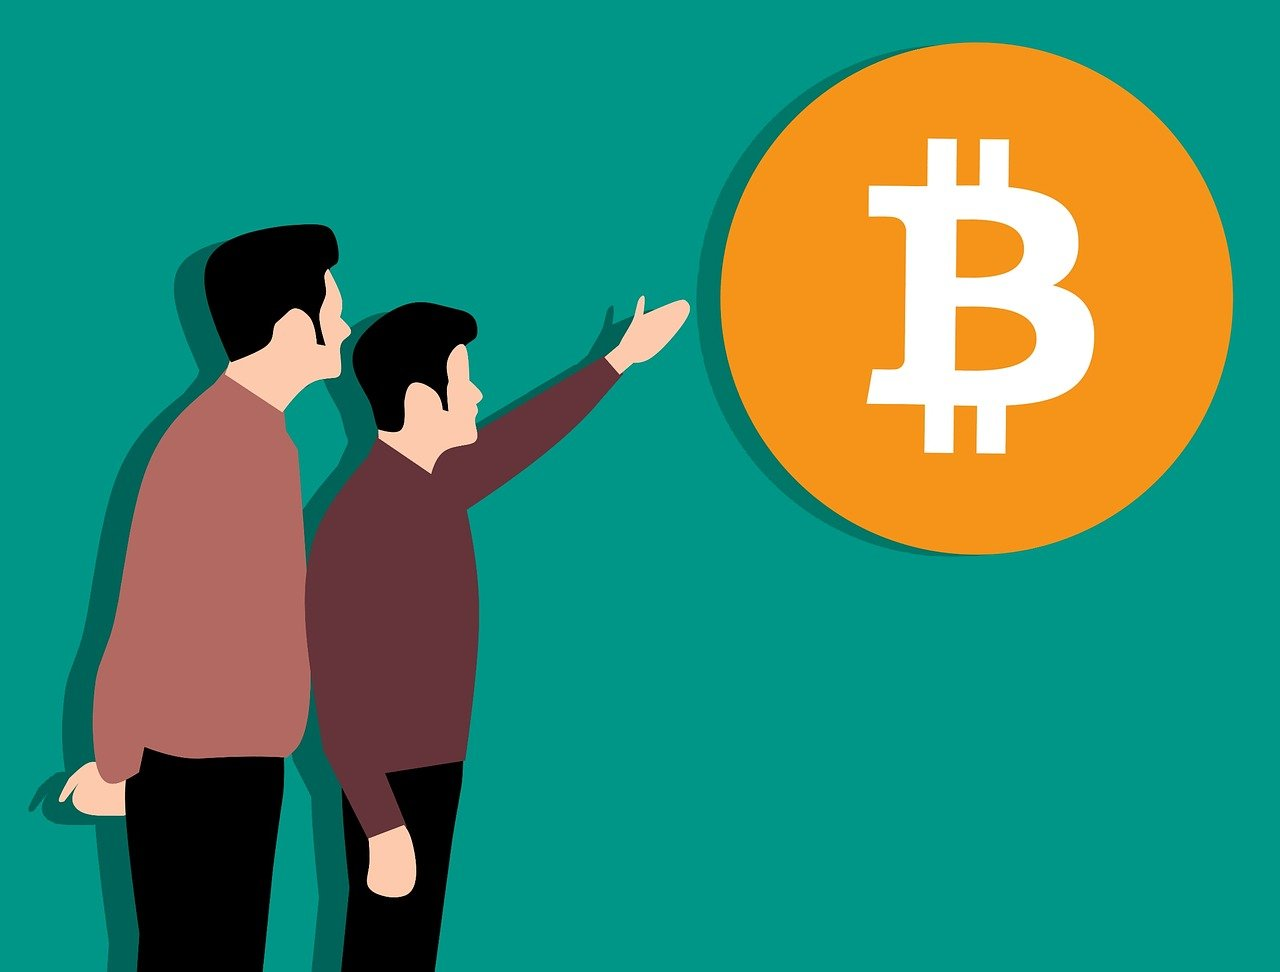

# Pre-Processing

In [ ]:
# First we will import the necessary Library 

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [ ]:

from numpy.random import seed
seed(1)
from tensorflow import keras
SEED = 1
keras.utils.set_random_seed(SEED)

In [ ]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(1)

In [ ]:
# Load our dataset 
# Note it should be in same dir


maindf=pd.read_csv('/content/drive/MyDrive/BTC/BTC-USD from2014 to 24-6-2022.csv')

In [ ]:
# Printing the start date and End date of the dataset

sd=maindf.iloc[0][0]
ed=maindf.iloc[-1][0]


print('Starting Date',sd)
print('Ending Date',ed)


Starting Date 2014-09-17
Ending Date 2022-06-24


In [ ]:
# Lets First Take all the Close Price 
closedf = maindf[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2838, 2)


In [ ]:
#Now we will Take data of just 1 Year

closedf = closedf[(closedf['Date'] > '2015-01-1') & (closedf['Date'] < '2022-06-15')]
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  2713


In [ ]:
# deleting date column and normalizing using MinMax Scaler

del closedf['Date']
realdf=closedf
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)
print(closedf)

(2713, 1)
[[0.00143485]
 [0.00129928]
 [0.00133098]
 ...
 [0.39449545]
 [0.33105368]
 [0.32688985]]


In [ ]:
# we keep the training set as 60% and 40% testing set

training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)
#print("train_data: ", train_data)
#print("test_data: ", test_data)


train_data:  (1627, 1)
test_data:  (1086, 1)


In [ ]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# **window=15**

In [ ]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (1611, 15)
y_train:  (1611,)
X_test:  (1070, 15)
y_test (1070,)


In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)


X_train:  (1611, 15, 1)
X_test:  (1070, 15, 1)


In [ ]:
y_test 

array([0.17775095, 0.16591142, 0.17269778, ..., 0.41821102, 0.39449545,
       0.33105368])

## **LOSS FUN**

In [ ]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

def custom_loss(y_true, y_pred):

    mse = tf.keras.losses.MeanSquaredError()

    penalty = 9

    # penalize the loss heavily if the actual and the prediction are on different sides of zero
    loss = tf.where(
        condition=tf.logical_or((tf.logical_and(tf.greater(y_true, 0.0), tf.less(y_pred, 0.0))), (tf.logical_and(tf.less(y_true, 0.0), tf.greater(y_pred, 0.0)))),
        x=mse(y_true, y_pred) * penalty,
        y=mse(y_true, y_pred) * penalty / 4
    )

    # add slightly more penalty if prediction overshoots actual in any direction
    loss = tf.where(
        condition=tf.logical_or((tf.logical_and(tf.greater(y_true, 0.0), tf.greater(y_pred, y_true))), 
                                (tf.logical_and(tf.less(y_true, 0.0), tf.less(y_pred, y_true)))),
        x=loss * penalty / 5,
        y=loss * penalty / 10
    )

    return loss

EPOCHS = 350
BATCH_SIZE = 32
MODEL_NAME = f"MODEL 01-{str(int(time.time()))}"


	

In [ ]:
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.layers import Dense, LSTM, Dropout, GRU
modelGRU = Sequential()

modelGRU.add(GRU(units=128,  input_shape=(X_train.shape[1],1),activation="relu"))
modelGRU.add(Dense(1))
modelGRU.summary()

opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-6)

checkpoint_path15 = 'my_best_model15.hdf5'

metric= tf.keras.metrics.MeanSquaredError()

modelGRU.compile(loss=custom_loss, optimizer=opt, metrics=[metric]) 

val_metric = 'val_'+metric.name


checkpoint15 = ModelCheckpoint(filepath=checkpoint_path15, monitor=val_metric, verbose=1,save_best_only=True, mode='min',metric=metric)


earlystopping = EarlyStopping(monitor=val_metric, patience=100, restore_best_weights=True)

callbacks = [checkpoint15, earlystopping]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               50304     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = modelGRU.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=300, 
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks= callbacks)

Epoch 1/300
48/51 [===========================>..] - ETA: 0s - loss: 0.0037 - mean_squared_error: 0.0015
Epoch 1: val_mean_squared_error improved from inf to 0.14220, saving model to my_best_model15.hdf5
51/51 [==============================] - 4s 31ms/step - loss: 0.0036 - mean_squared_error: 0.0015 - val_loss: 0.2880 - val_mean_squared_error: 0.1422
Epoch 2/300
50/51 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0021
Epoch 2: val_mean_squared_error improved from 0.14220 to 0.12815, saving model to my_best_model15.hdf5
51/51 [==============================] - 1s 20ms/step - loss: 0.0052 - mean_squared_error: 0.0021 - val_loss: 0.2595 - val_mean_squared_error: 0.1282
Epoch 3/300
50/51 [============================>.] - ETA: 0s - loss: 0.0061 - mean_squared_error: 0.0020
Epoch 3: val_mean_squared_error did not improve from 0.12815
51/51 [==============================] - 1s 19ms/step - loss: 0.0060 - mean_squared_error: 0.0020 - val_loss: 0.2773 - val

In [ ]:
### Plotting Loss vs Validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
from keras.models import load_model
model_from_saved_checkpoint15 = load_model('/content/my_best_model15.hdf5', custom_objects={'custom_loss':                   
custom_loss})

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model_from_saved_checkpoint15.predict(X_train)
test_predict=model_from_saved_checkpoint15.predict(X_test)
train_predict.shape, test_predict.shape

In [ ]:
# Model Evaluation
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
print('test_predict \n' ,test_predict[-10:-1,])
print('=====================================')
print('original_ytest \n', original_ytest[-10:-1,])

## `RESULT W=15`

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

In [ ]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

In [ ]:
## Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

## Custom Score 

In [ ]:
import numpy as np

def Y_score(targets,predictions):
    n = len(predictions)
    sum_n = 0
    sum_p = 0
    cn=0
    cp=0  
    # for loop for iteration
    for i in range(n):
        d =((targets[i] - predictions[i])/targets[i])
        if d < 0 :
          sum_n += d
          cn+=1
        else :
          sum_p += d 
          cp +=1 
    if cn == 0 :
       cn=1   
    if cp== 0 :
       cp=1         
    error_n = sum_n/cn 
    error_p =sum_p/cp  
    total_error = error_p + error_n
    # display
    print("Y error nigative : " + str(error_n))
    print("Y error positive : " + str(error_p))
    print("Y total_error : " + str(total_error))

In [ ]:
Y_score(original_ytrain, train_predict)

In [ ]:
Y_score(original_ytest, test_predict)

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()



```
# This is formatted as code
```



In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

##  Predicting next 7 days
DEPENDING ON BEST WINDOW (W=)



In [ ]:
time_step=15
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 5
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model_from_saved_checkpoint15.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        print('================')
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_from_saved_checkpoint15.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

## Plotting last 15 days of dataset and next predicted 7 days

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat
last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
print("last_original_days_value")
print(last_original_days_value[0:time_step])
print("next_predicted_days_value")
print(next_predicted_days_value[time_step+1:])

In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


# **window=30**

In [ ]:
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)


In [ ]:
y_test 

## LOSS FUN

In [ ]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

def custom_loss(y_true, y_pred):

    mse = tf.keras.losses.MeanSquaredError()

    penalty = 9

    # penalize the loss heavily if the actual and the prediction are on different sides of zero
    loss = tf.where(
        condition=tf.logical_or((tf.logical_and(tf.greater(y_true, 0.0), tf.less(y_pred, 0.0))), (tf.logical_and(tf.less(y_true, 0.0), tf.greater(y_pred, 0.0)))),
        x=mse(y_true, y_pred) * penalty,
        y=mse(y_true, y_pred) * penalty / 4
    )

    # add slightly more penalty if prediction overshoots actual in any direction
    loss = tf.where(
        condition=tf.logical_or((tf.logical_and(tf.greater(y_true, 0.0), tf.greater(y_pred, y_true))), (tf.logical_and(tf.less(y_true, 0.0), tf.less(y_pred, y_true)))),
        x=loss * penalty / 5,
        y=loss * penalty / 10
    )

    return loss

EPOCHS = 350
BATCH_SIZE = 32
MODEL_NAME = f"MODEL 01-{str(int(time.time()))}"


	

In [ ]:
import keras.backend as K
from keras.layers import Dense, LSTM, Dropout, GRU

modelGRU = Sequential()
modelGRU.add(GRU(units=128,  input_shape=(X_train.shape[1],1),activation="relu"))
modelGRU.add(Dense(1))
modelGRU.summary()


opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-6)

checkpoint_path30 = 'my_best_model30.hdf5'

metric= tf.keras.metrics.MeanSquaredError()

modelGRU.compile(loss=custom_loss, optimizer=opt, metrics=[metric]) 

val_metric = 'val_'+metric.name


checkpoint30 = ModelCheckpoint(filepath=checkpoint_path30, monitor=val_metric, verbose=1,save_best_only=True, mode='min',metric=metric)


earlystopping = EarlyStopping(monitor=val_metric, patience=100, restore_best_weights=True)

callbacks = [checkpoint30, earlystopping]


In [ ]:
history = modelGRU.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=300, 
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks= callbacks)

In [ ]:
### Plotting Loss vs Validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
from keras.models import load_model
model_from_saved_checkpoint30 = load_model('/content/my_best_model30.hdf5', custom_objects={'custom_loss':                   
custom_loss})

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model_from_saved_checkpoint30.predict(X_train)
test_predict=model_from_saved_checkpoint30.predict(X_test)
train_predict.shape, test_predict.shape

In [ ]:
# Model Evaluation
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
print('test_predict \n' ,test_predict[-10:-1,])
print('=====================================')
print('original_ytest \n', original_ytest[-10:-1,])


## `RESULT W=30`

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

In [ ]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

In [ ]:
## Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

## Custom Score 

In [ ]:
import numpy as np

def Y_score(targets,predictions):
    n = len(predictions)
    sum_n = 0
    sum_p = 0
    cn=0
    cp=0  
    # for loop for iteration
    for i in range(n):
        d =((targets[i] - predictions[i])/targets[i])
        if d < 0 :
          sum_n += d
          cn+=1
        else :
          sum_p += d 
          cp +=1 
    if cn == 0 :
       cn=1   
    if cp== 0 :
       cp=1         
    error_n = sum_n/cn 
    error_p =sum_p/cp  
    total_error = error_p + error_n
    # display
    print("Y error nigative : " + str(error_n))
    print("Y error positive : " + str(error_p))
    print("Y total_error : " + str(total_error))

In [ ]:
Y_score(original_ytrain, train_predict)

In [ ]:
Y_score(original_ytest, test_predict)

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()



```
# This is formatted as code
```



In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()



```
# This is formatted as code
```



##  Predicting next 7 days
DEPENDING ON BEST WINDOW (W=)



In [ ]:
time_step=30
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 5
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model_from_saved_checkpoint30.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        print('================')
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_from_saved_checkpoint30.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

## Plotting last 30 days of dataset and next predicted 15 days

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat
last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
print("last_original_days_value")
print(last_original_days_value[0:time_step])
print("next_predicted_days_value")
print(next_predicted_days_value[time_step+1:])

In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 30 days close price','Predicted next 15 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


# **window=60**

In [ ]:
time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

In [ ]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)


In [ ]:
y_test 

## **LOSS FUN**

In [ ]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

def custom_loss(y_true, y_pred):

    mse = tf.keras.losses.MeanSquaredError()

    penalty = 9

    # penalize the loss heavily if the actual and the prediction are on different sides of zero
    loss = tf.where(
        condition=tf.logical_or((tf.logical_and(tf.greater(y_true, 0.0), tf.less(y_pred, 0.0))), (tf.logical_and(tf.less(y_true, 0.0), tf.greater(y_pred, 0.0)))),
        x=mse(y_true, y_pred) * penalty,
        y=mse(y_true, y_pred) * penalty / 4
    )

    # add slightly more penalty if prediction overshoots actual in any direction
    loss = tf.where(
        condition=tf.logical_or((tf.logical_and(tf.greater(y_true, 0.0), tf.greater(y_pred, y_true))), (tf.logical_and(tf.less(y_true, 0.0), tf.less(y_pred, y_true)))),
        x=loss * penalty / 5,
        y=loss * penalty / 10
    )

    return loss

EPOCHS = 350
BATCH_SIZE = 32
MODEL_NAME = f"MODEL 01-{str(int(time.time()))}"


	

In [ ]:
import keras.backend as K
from keras.layers import Dense, LSTM, Dropout, GRU

modelGRU = Sequential()
modelGRU.add(GRU(units=128,  input_shape=(X_train.shape[1],1),activation="relu"))
modelGRU.add(Dense(1))
modelGRU.summary()


opt = tf.keras.optimizers.Adam(learning_rate=1e-3, decay=1e-6)

checkpoint_path60 = 'my_best_model60.hdf5'

metric= tf.keras.metrics.MeanSquaredError()

modelGRU.compile(loss=custom_loss, optimizer=opt, metrics=[metric]) 

val_metric = 'val_'+metric.name


checkpoint60 = ModelCheckpoint(filepath=checkpoint_path60, monitor=val_metric, verbose=1,save_best_only=True, mode='min',metric=metric)


earlystopping = EarlyStopping(monitor=val_metric, patience=100, restore_best_weights=True)

callbacks = [checkpoint60, earlystopping]


In [ ]:
history = modelGRU.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE,
                    epochs=300, 
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks= callbacks)

In [ ]:
### Plotting Loss vs Validation loss
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
from keras.models import load_model
model_from_saved_checkpoint60 = load_model('/content/my_best_model60.hdf5', custom_objects={'custom_loss':                   
custom_loss})

In [ ]:
### Lets Do the prediction and check performance metrics
train_predict=model_from_saved_checkpoint60.predict(X_train)
test_predict=model_from_saved_checkpoint60.predict(X_test)
train_predict.shape, test_predict.shape

In [ ]:
# Model Evaluation
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [ ]:
print('test_predict \n' ,test_predict[-10:-1,])
print('=====================================')
print('original_ytest \n', original_ytest[-10:-1,])


## `RESULT W=60

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

In [ ]:
print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

In [ ]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

In [ ]:
## Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

## Custom Score 

In [ ]:
import numpy as np

def Y_score(targets,predictions):
    n = len(predictions)
    sum_n = 0
    sum_p = 0
    cn=0
    cp=0  
    # for loop for iteration
    for i in range(n):
        d =((targets[i] - predictions[i])/targets[i])
        if d < 0 :
          sum_n += d
          cn+=1
        else :
          sum_p += d 
          cp +=1 
    if cn == 0 :
       cn=1   
    if cp== 0 :
       cp=1         
    error_n = sum_n/cn 
    error_p =sum_p/cp  
    total_error = error_p + error_n
    # display
    print("Y error nigative : " + str(error_n))
    print("Y error positive : " + str(error_p))
    print("Y total_error : " + str(total_error))

In [ ]:
Y_score(original_ytrain, train_predict)

In [ ]:
Y_score(original_ytest, test_predict)

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (2713, 1)
Test predicted data:  (2713, 1)


##  Predicting next 7 days
DEPENDING ON BEST WINDOW (W=)



In [ ]:
time_step=60
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 5
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model_from_saved_checkpoint60.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        print('================')
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_from_saved_checkpoint60.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

## Plotting last 60 days of dataset and next predicted 15 days

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat
last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]
print("last_original_days_value")
print(last_original_days_value[0:time_step])
print("next_predicted_days_value")
print(next_predicted_days_value[time_step+1:])

In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 30 days close price','Predicted next 15 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()
